In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage import color

video_folder = '/content/snimci'

if os.path.exists(video_folder):
    print(f"Folder '{video_folder}' found.")

    # List all files in the folder
    files = os.listdir(video_folder)

    # Separate video and CSV files
    video_files = [f for f in files if f.endswith(('.mkv','.mp4'))]
    csv_files = [f for f in files if f.endswith('.csv')]

    # Find matching file pairs (same name down to extension)
    matched_pairs = []
    for video_file in video_files:
        # Remove file extension to find matching CSV
        base_name = os.path.splitext(video_file)[0]
        if f"{base_name}.csv" in csv_files:
            matched_pairs.append((video_file, f"{base_name}.csv"))

    # Print the matched pairs
    if matched_pairs:
        print("Matching video and CSV file pairs:")
        for video, csv in matched_pairs:
            print(f"Video: {video}, CSV: {csv}")
    else:
        print("No matching video and CSV file pairs found.")
else:
    print(f"Folder '{video_folder}' not found.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder '/content/drive/MyDrive' found.
Matching video and CSV file pairs:
Video: S3 FX 2024-05-16 14-01-54.mkv, CSV: S3 FX 2024-05-16 14-01-54.csv
Video: S2 FX 2024-05-16 14-00-06.mkv, CSV: S2 FX 2024-05-16 14-00-06.csv
Video: S1 FX s2024-05-16 13-58-01.mkv, CSV: S1 FX s2024-05-16 13-58-01.csv
Video: S4 FX 2024-05-16 14-04-09.mkv, CSV: S4 FX 2024-05-16 14-04-09.csv


# New Section

In [ ]:
# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over all files in the video folder
for file_name in os.listdir(video_folder):
    if not file_name.endswith(('.mkv', '.mp4')):  continue

    # Find the corresponding CSV file
    base_name = os.path.splitext(file_name)[0]
    csv_path = os.path.join(video_folder, f"{base_name}.csv")

    if not os.path.exists(csv_path):  continue

    video_path = os.path.join(video_folder, file_name)
    print(f"Processing video: {video_path} with CSV: {csv_path}")

    # Read the CSV file
    roi_data = pd.read_csv(csv_path)
    first_frame_no = roi_data['First frame'][0]
    duration = 60*30  # Calculate duration based on frame range

    for index, row in roi_data.iterrows():
        x_roi = round(row['Top Left X'])
        y_roi = round(row['Top Left Y'])
        width_roi = round(row['Bottom Right X'] - x_roi)
        height_roi = round(row['Bottom Right Y'] - y_roi)

        image_stack = []
        br = 0
        video_reader = cv2.VideoCapture(video_path)

        # Read frames from the video
        while True:
            ret, frame = video_reader.read()
            br += 1
            if br < first_frame_no:
                continue
            if not ret or br >= first_frame_no + duration:
                break

            if br >= first_frame_no:
                frameShrink = frame[y_roi:y_roi+height_roi, x_roi:x_roi+width_roi]
                gray_frame = color.rgb2gray(frameShrink)
                image_stack.append(gray_frame)
                print(f"Processing frame {br}")

        # Save the image stack as a .npy file
        np_filename = f"{base_name}_{index + 1}.npy"
        np.save(os.path.join(output_folder, np_filename), np.uint8(np.array(image_stack)*255))
        print(f"Saved {np_filename} with {len(image_stack)} frames.")
        video_reader.release()

    #os.remove(np_filename)


Streaming output truncated to the last 5000 lines.
Processing frame 646
Processing frame 647
Processing frame 648
Processing frame 649
Processing frame 650
Processing frame 651
Processing frame 652
Processing frame 653
Processing frame 654
Processing frame 655
Processing frame 656
Processing frame 657
Processing frame 658
Processing frame 659
Processing frame 660
Processing frame 661
Processing frame 662
Processing frame 663
Processing frame 664
Processing frame 665
Processing frame 666
Processing frame 667
Processing frame 668
Processing frame 669
Processing frame 670
Processing frame 671
Processing frame 672
Processing frame 673
Processing frame 674
Processing frame 675
Processing frame 676
Processing frame 677
Processing frame 678
Processing frame 679
Processing frame 680
Processing frame 681
Processing frame 682
Processing frame 683
Processing frame 684
Processing frame 685
Processing frame 686
Processing frame 687
Processing frame 688
Processing frame 689
Processing frame 690
Proc

In [ ]:
# Define the path for the deflicker folder
deflicker_folder = '/content/Vedrana_deflicker'

# Ensure the deflicker folder exists
if not os.path.exists(deflicker_folder):
    os.makedirs(deflicker_folder)

# Iterate over all numpy files in the Vedrana_numpy folder
for np_file in os.listdir(output_folder):
    np_file_path = os.path.join(output_folder, np_file)
    image_stack = np.load(np_file_path) / 255
    os.remove(np_file_path)
    print(f"Original file {np_file_path} deleted.")
    frame_count = image_stack.shape[0]

    a = 0.9
    prev_luminance_avg = np.mean(image_stack[0, :, :])
    for br in range(1, frame_count):
        frame = image_stack[br, :, :]
        prev_frame = image_stack[br-1, :, :]
        luminance_avg = np.mean(frame)

        if abs(luminance_avg - prev_luminance_avg) > (1 - a) * luminance_avg:
            prev_luminance_avg = luminance_avg
        else:
            prev_luminance_avg = luminance_avg * a + (1 - a) * prev_luminance_avg
            scale = prev_luminance_avg / luminance_avg
            adjusted_frame = np.clip(frame * scale, 0, 1)

            soft_low = 0.05 * luminance_avg
            soft_high = 0.10 * luminance_avg
            diff = abs(prev_frame - adjusted_frame)
            mask = np.logical_and(diff > soft_low, diff < soft_high)
            final = adjusted_frame.copy()

            final[mask] = (adjusted_frame[mask] * 2 + prev_frame[mask]) / 3
            mask = (diff <= soft_low)
            final[mask] = prev_frame[mask]

            image_stack[br, :, :] = final

            print(f"Processed frame {br}/{frame_count} of {np_file}")

    # Save the deflickered image stack in the deflicker folder
    deflicker_file_path = os.path.join(deflicker_folder, np_file)
    np.save(deflicker_file_path, np.uint8(image_stack * 255))
    print(f"Deflickered stack saved as {deflicker_file_path}")


Streaming output truncated to the last 5000 lines.
Processed frame 403/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 404/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 405/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 406/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 407/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 408/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 409/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 410/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 411/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 412/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 413/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 414/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 415/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 416/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 417/1800 of S3 FX 2024-05-16 14-01-54_2.npy
Processed frame 418/1800 of S3 FX 2024-05-16 14-0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import heapq
import copy
from skimage import morphology
from scipy.ndimage import median_filter
from skimage import color, filters, measure
import pandas as pd


def region_growing_bfs(image, seed_point, threshold):
    height, width = image.shape
    visited = np.zeros_like(image, dtype=bool)
    segmented_image = np.zeros_like(image)
    queue = [(image[seed_point], seed_point)]
    heapq.heapify(queue)
    segmented_image[seed_point] = 255
    visited[seed_point] = True

    while queue:
        _, current_point = heapq.heappop(queue)
        y, x = current_point

        # Explore neighbors in all 8 directions
        neighbors = [(y + dy, x + dx) for dy in [-1, 0, 1] for dx in [-1, 0, 1] if (dy != 0 or dx != 0)]

        # Create a priority queue for neighbors based on pixel value
        neighbor_queue = [(image[ny, nx], (ny, nx)) for ny, nx in neighbors if 0 <= ny < height and 0 <= nx < width and not visited[ny, nx] and (image[ny, nx] > image[y, x] or image[ny, nx] < threshold)]
        heapq.heapify(neighbor_queue)

        while neighbor_queue:
            _, neighbor_point = heapq.heappop(neighbor_queue)
            ny, nx = neighbor_point
            if not visited[ny, nx]:
                segmented_image[ny, nx] = 255
                visited[ny, nx] = True
                heapq.heappush(queue, (image[ny, nx], (ny, nx)))  # Add to main queue for next depth level

    return segmented_image

def find_movement(image_stack):
  median_frame = np.median(image_stack, axis=0)
  max_frame = np.max(image_stack, axis=0)

  diff_image = max_frame - median_frame
  mask = diff_image > 70
  median_frame[mask] = max_frame[mask]

  blob_data = pd.DataFrame(columns=['x', 'y', 'area', 'eccentricity', 'frame'])
  for c in range(len(image_stack)):
    current_frame = image_stack[c, :, :]
    print(c)
    movement_frame = current_frame - median_frame
    movement_frame = 255 - np.abs(np.clip(movement_frame, None, 0))
    movement_frame = median_filter(movement_frame, size=3)

    labeled_image = np.zeros_like(movement_frame, dtype=int)
    label = 1
    cnt = 0
    while cnt < 10:
      cnt = cnt + 1
      if np.min(movement_frame) == 255: break
      min_coords = np.unravel_index(np.argmin(movement_frame), movement_frame.shape)
      segmented_region = region_growing_bfs(movement_frame, min_coords, 220)
      num_pixels = np.count_nonzero(segmented_region)
      movement_frame[segmented_region == 255] = 255
      if num_pixels <= 50 or num_pixels >= 2500:
          cnt = cnt - 1
          continue

      labeled_image[segmented_region == 255] = label
      label += 1
    regions = measure.regionprops(labeled_image)

    # Collect blob data
    frame_data = pd.DataFrame({
        'x': [region.centroid[1] for region in regions],
        'y': [region.centroid[0] for region in regions],
        'area': [region.area for region in regions],
        'eccentricity': [region.eccentricity for region in regions],
        'frame': c
    })
    blob_data = pd.concat([blob_data, frame_data], ignore_index=True)
  return blob_data

def process_file(file):
    image_stack = np.load(os.path.join(deflicker_folder, file))
    blob_data = find_movement(image_stack)

    n = file.split('_')[-1].replace('.npy', '')
    filename = f"{file.split('_')[0:-1][0]}_detections_{n}.csv"
    blob_data.to_csv(filename, index=False)
    print(f"Processed {file}")


from concurrent.futures import ThreadPoolExecutor

deflicker_folder = '/content/Vedrana_deflicker'
np_file = [file for file in os.listdir(deflicker_folder) if file.endswith(".npy")]

# Parallel processing with ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(process_file, np_file)



0
0


<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
1
22

0
30

3
4
1
1
4


<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


5
2
5
2
6
3
6
3
7
4
7
8
4
5
9
8
5
6
10
9
6
11
7
7
10
12
8
8
11
13
9
12
149

13
10
10
15
14
16
11
11
17
15
12
12
16
1318

13
17
19
14
14
18
20
15
15
19
21
16
202216


17
23
21
17
22
24
18
18
23
25
19
19
20
2426

20
21
25
27
2228

26
21
27
22
23
29
28
3024

23
29
31
25
24
30
32
26
25
31
33
27
26
34
32
28
35
2927

33
28
36
30
34
29
37
31
35
38
3230

36
39
31
33
37
32
34
40
38
33
35
41
39
36
34
40
37
42
35
38
41
36
39
42
43
37
40
43
44
38
45
41
44
46
4539

42
46
43
47
40
47
4448

41
48
49
45
42
50
46
49
43
50
51
47
44
51
45
52
48
46
52
4953

50
53
47
54
54
51
4855

52
49
55
56
5350

56
57
54
51
57
55
52
58
58
56
53
59
59
57
54
60
58
61
60
55
59
62
56
61
63
60
57
61
64
58
62
65
62
59
66
6063

63
61
64
67
64
68
65
62
65
69
66
63
66
64
67
67
70
65
68
68
71
6669

69
72
70
67
70
71
73
68
71
72
7469

72
73
75
70
73
74
76
71
74
75
72
77
75
76
73
78
76
74
77
79
77
75
78
80
78
76
79
81
79
77
80
82
78
80
81
79
81
83
82
80
82
84
83
81
83
85
84
82
84
85
86
83
86
85
87
84
87
88
86
85
88
87
86
89
88
89


<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


416199

2
417
200
3
201
418
4
5202

419
203
6
420
7
204
421
8
205
422
9
206
423
10
207
208
424
209
210425

11
211
426
212
427
213
12
428
214
13
429
215
14
216
430
15
217
431
16
218
432
219
433
220
17
434
221
435
18
222
436
19
223
437
224
438
225
20
226
439
227
21
440
228
441
229
230
442
231
443
22
232
444
233
23
234
445
24
235446

25
236
447
26
237
448
238
27
449
239
450
240
451
241
452
242
453
243
454
244
245455

246
456
247
457
248
458
249
250
459
251
460
252
253
461
254
462
255
256
463
257
464
258
465
259
466
260
467
261
468
262
263
469
264
470
265
471
266
267
472
268473

474
269
475
270
271
476
272
477
273
478
274
479
275
276
480
277
481
278
482
373
279
280
483
281
484
282
485
283
486
284
487
285
286
488
287
489
288
289
490
290
291
491
292
293
492
294
295
493
296
494
297
495
298
496
299
497
300
498
301
302
499
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
500
324
325
501
326
327
502
328
503
329
504
330
331
505
332
333
506
334
335
507
336
337
50

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
2
3
4
5
6
7
766
8
9
71
10
11
12
13
391
14
15
16
17
18
19
20
21
767
22
72
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
768
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
769
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
770
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
771
108
109
110
111
112
113
114
115
116
117
118
119
120
392
121
122
123
124
125
126
127
128
772
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
773
154
155
156
157
158
159
160
161
162
163
164
165
166
774
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
775
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
776
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
777
232
393
233
234
235
236
237
238
239
240
241
242
243
244
245
246
778
247
248
249
250
251
252
253
254
255
256
257
258
259
26

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
2
3
4
5
6
7
8
9
10
684
11
12
13
14
15
0
16
1


<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


17
2
18
3
19
20
4
21
5
22
23
6
24
7
25
8
26
9
27
10
28
29
11
12
30
685
31
13
32
14
33
15
34
16
35
17
36
18
37
38
19
39
20
40
41
21
42
22
43
23
24
44
45
25
46
47
26
48
49
27
50
51
686
28
52
53
29
54
30
55
56
31
57
58
32
59
60
33
61
34
62
35
63
36
64
65
37
66
38
39
67
68
40
69
41
70
42
71
43
72
44
73
45
74
46
75
47
48
687
76
77
49
50
78
79
51
80
52
81
53
82
54
83
55
56
84
85
57
86
58
59
87
60
88
89
61
62
90
91
63
92
64
65
93
94
66
95
67
68
96
97
69
98
70
71
99
688
72
100
73
101
102
74
103
75
104
76
105
77
106
78
107
108
79
109
80
81
110
82
111
112
83
113
84
114
85
115
116
86
117
87
88
118
89
119
90
120
91
689
121
92
12293

94
123
95
124
96
125
97
126
98
173
127
99
128
100
129
101
130
102
131
103
132
104
133
105
134
106
135
107
108
109
110
111
136
112
137
113
138
114
139
115
140
116
141
117
690
142
118
143
119
120144

121
145
122
146
123
147
124
148
125
149
126
150
127
151
128
152
153
129
154
130
155
131
156
132
174
157
133
158
134
159
135
160
136
161
137
691
162
138
163
139
164
165
140
1

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
829
21
22
23
24
25
26
194
27
28
29
30
31
32
33
34
35
345
36
37
38
39
40
41
830
42
43
44
45
46
47
48
49
50
51
52
53
54
831
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
832
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
346
833
95
347
96
97
98
99
100
101
102
103
104
105
106
107
108
834
109
110
111
112
113
114
115
116
117
118
119
120
121
835
122
123
195
124
125
196
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
836
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
348
157
158
159
160
837
161
162
163
164
165
166
167
168
169
170
171
838
172
839
173
840
174
841
175
842
176
843
177
844
178
845
179
846
847
180
848
181
182
849
183
850
184
851
185
852
186
853
187
854
188
189
855
190
856
191
857
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
858
211
212
213
214
349
215
216
217
218
219
220
221
222
223
224
859
225
226
227
228
229
230
231
232
233
234
235
236
237
860


<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
2
3
4
5
6
7
980
8
9
10
11
12
230
13
14
15
16
981
17
18
19
20
21
22
23
24
982
25
26
27
28
29
30
31
32
983
33
34
35
383
36
37
984
38
39
40
41
42
43
44
45
46
47
48
985
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
986
987
70
71
72
73
74
75
76
77
988
78
989
79
80
81
82
83
84
85
990
86
384
87
88
89
90
91
92
93
94
991
95
96
97
98
99
100
101
102
103
104
105
992
106
107
993
994
108
995
109
110
111
231
112
113
114
115
116
117
118
119
120
996
121
122
123
124
125
126
127
128
129
997
130
131
132
133
998
385
999
1000
1001
1002
1003
1004
1005
386
1006
232
134
1007
1008
387
1009
1010
388
135
1011
136
233
1012
1013
389
1014
1015
137
390
1016
234
235
1017
1018
391
138
1019
1020
236
1021
392
1022
139
1023
393
1024
237
1025
140
141
1026
394
1027
1028
238
239
395
1029
142
143
144
145
146
147
148
1030
1031
1032
396
1033
1034
240
241
242
243
149
1035
397
1036
1037
1038
1039
1040
150
398
151
152
153
154
155
1561041

157
158
159
160
161
162
163
164
165
166
167
168
169
1042
170
171
172
173
1

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
2
3
4
5
6
397
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
1602
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
398
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
36276

77
1603
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
399
111
112
113
114
115
116
117
118
119
120
121
122
123
1604
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
1605
162
163
400
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
1606
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
401
218
219
402
403
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
1607
244
245
246
247
248
249
250
251
252
363
253
254
255
256
257
258
259
260
26

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
983
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1685
984
56
57
985
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
986
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
384
113
114
385
115
386
1686
116
387
117
388
118
119
120
121
122
123
124
125
126
127
128
129
987
130
131
988
132
989
133
134
135
990
136
991
137
138
992
139
140
993
141
142
994
143
995
144
145
146
996
147
148
997
149
150
998
151
999
152
153
1000
154
155
1001
156
1002
157
158
1003
159
160
1004
161
1005
162
163
1006
164
165
1007
166
1008
167
168
1009
169
170
1010
171
172
1011
173
174
1012
175
176
1013
1687
177
178
10141688

179
1689
180
1015
1690
181
1016
182
183
1017
184
185
1018
186
187
1019
188
189
1020
190
191
192
1021
193
194
195
196
1022
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
2

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
173624

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
1737
85
86
87
423
88
89
90
1428
91
92
93
1429
94
95
1430
96
97
1431
98
1432
99
100
1433
101
102
1434
103
104
1051435

106
1436
107
108
1437
109
110
1438
111
112
1439
113
1440
114
115
1441
116
117
1442
118
1443
119
120
1444
121
122
1445
123
1446
124
125
1447
126
1448
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
1738
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
1739
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
2

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


2
1010
3
1011
4
1012
5
1013
1014
6
7
1015
8
1016
9
10
1017
11
1018
12
1019
1020
13
1021
14
1022
15
1023
16
1024
17
1025
18
1026
19
1027
1028
20
1029
21
1030
22
1031
23
1032
24
1033
1034
25
1035
26
1036
27
1037
28
1038
29
1039
30
1040
31
1041
32
1042
33
34
1043
35
1044
36
37
38
39
40
41
42
43
44
45
46
47
48
49
458
50
51
52
459
53
54
460
55
56
57
461
58
462
59
463
60
61
464
62
465
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
1464
88
89
90
91
92
93
94
95
1045
96
1046
97
1047
98
99
1048
100
1049
1050
101
102
1051
103
1052
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
1053
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
1465
201
202
203
204
205
206
207
466
208
209
467
210


<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
900
2
901
902
3
903
4
904
5
905
6
906
7
907
8
908
909
9
910
10
911
11
912
12
913
13
914
14
915
15
916
16
917
17
918
18
919
19
20920

21
921
22
922
23
923
24
924
25
925
26
926
27
927
28
29
928
30
929
31
930
32
931
33
932
34
933
35
934
36
935
37
936
38
937
39
938
40
939
41
940
42
941
43
942
44
943
45
46
944
47
945
48
94649

50
947
51
948
52
53
949
54
950
55
951
56
952
57
953
58
954
59
955
60
956
61
957
958
62
959
63
960
64
961
65
962
66
963
67
964
965
68
69
966
70
967
968
71
969
72
73
970
74
971
75
972
76
973
77
974
78
975
79
976
80
496
81
977
82
978
83
84
979
85
980
86
981
87
982
88
983
1485
89
984
90
985
91
986
987
92
988
93
989
94
990
95
991
96
97
992
98
993
99
994
100
995
101
102
996
103
997
104
998
105
999
106
107
1000
108
109
110
1001
111
1002
112
113
1003
114
115
1004
116
117
1005
118
1006
119
120
1007
121
1008
122
123
124
1009
125
1010
126
1011
127
128
1012
129
1013
130
131
1014
132
1015
133
134
1016
135
1017
136
1018
137
1019
138
139
1020
140
1021
1022
141
142
1023
1024143

14

<ipython-input-4-012b8e53ee20>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blob_data = pd.concat([blob_data, frame_data], ignore_index=True)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
507
109
110
111
112
1500
113
114
115
116
117
118
119
120
121
122
123
124
125
236
126
127
128
237
129
130
131
132
238
133
239
134
135
136
240
137
138
139
140
141
142
143
144
145
146
147
148
1501
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
1502
184
1851503

186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
1504
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
150

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the path for the deflicker folder
deflicker_folder = '/content/Vedrana_deflicker'

# Load a single image stack (for example, the first file in the folder)
np_file = os.listdir(deflicker_folder)[-3]
print(np_file)
image_stack = np.load(os.path.join(deflicker_folder, np_file))
# Determine frame count
frame_count = image_stack.shape[0]

# Calculate median and max frames
median_frame = np.median(image_stack, axis=0)
max_frame = np.max(image_stack, axis=0)




FileNotFoundError: [Errno 2] No such file or directory: '/content/Vedrana_deflicker'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import heapq
import copy
from skimage import morphology
from scipy.ndimage import median_filter

deflicker_folder = '/content/drive/MyDrive'
np_file = []
for file in os.listdir(deflicker_folder):
  if file.endswith(".npy"):
    np_file.append(file)

# Load a single image stack (for example, the first file in the folder)
np_file = np_file[-11]
print(np_file)
image_stack = np.load(os.path.join(deflicker_folder, np_file))
# Determine frame count
frame_count = image_stack.shape[0]

# Calculate median and max frames
median_frame = np.median(image_stack, axis=0)
max_frame = np.max(image_stack, axis=0)

In [ ]:
print(np_file)


S6 FX 2024-05-16 14-11-14_1.npy


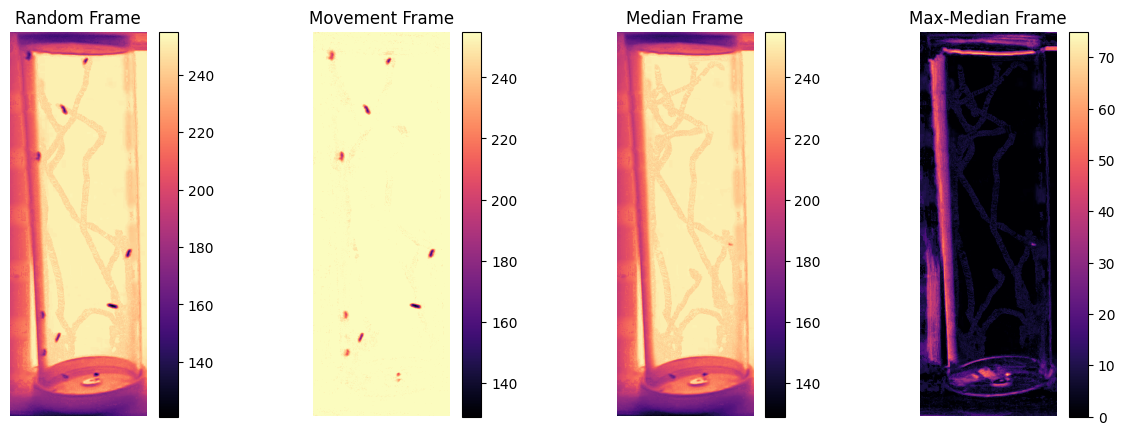

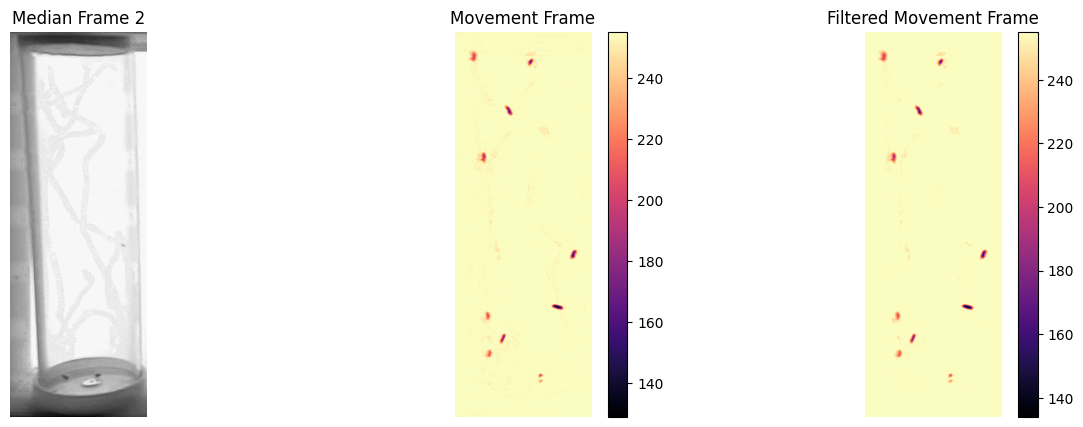

In [ ]:
# Select a random frame from the image stack
random_frame = image_stack[np.random.randint(0, frame_count), :, :]

# Calculate movement frame
movement_frame = random_frame - median_frame
movement_frame = 255 - abs(np.clip(movement_frame, None, 0))

# Create a 1x4 subplot layout
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Display the random frame
im1 = axes[0].imshow(random_frame, cmap='magma')
axes[0].axis('off')
axes[0].set_title("Random Frame")
plt.colorbar(im1, ax=axes[0])

# Display the movement frame
im2 = axes[1].imshow(movement_frame, cmap='magma')
axes[1].axis('off')
axes[1].set_title("Movement Frame")
plt.colorbar(im2, ax=axes[1])

# Display the median frame
im3 = axes[2].imshow(median_frame, cmap='magma')
axes[2].axis('off')
axes[2].set_title("Median Frame")
plt.colorbar(im3, ax=axes[2])

# Display the max frame minus median frame
im4 = axes[3].imshow(max_frame - median_frame, cmap='magma')
axes[3].axis('off')
axes[3].set_title("Max-Median Frame")
plt.colorbar(im4, ax=axes[3])

# Show the plot
plt.show()

# Calculate difference image and binary mask
diff_image = max_frame - median_frame
mask = diff_image > 70

median_frame2 = copy.deepcopy(median_frame)
# Apply mask to median_frame
median_frame2[mask] = max_frame[mask]

# Calculate new movement frame
movement_frame2 = random_frame - median_frame2
movement_frame2 = 255 - abs(np.clip(movement_frame2, None, 0))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Display median_frame2
ax1.imshow(median_frame2, cmap='gray')
ax1.axis('off')
ax1.set_title("Median Frame 2")

# Display the movement frame
im1 = ax2.imshow(movement_frame2, cmap='magma')
fig.colorbar(im1, ax=ax2)
ax2.axis('off')
ax2.set_title("Movement Frame")

# Display the filtered movement frame
im2 = ax3.imshow(median_filter(movement_frame2, size=3), cmap='magma')
fig.colorbar(im2, ax=ax3)
ax3.axis('off')
ax3.set_title("Filtered Movement Frame")

# Show the plot
plt.show()


354 219.20621468926555
370 228.8864864864865
346 228.59537572254337
270 234.25925925925927
309 233.28802588996763
418 236.77511961722487
502 239.38446215139442
304 240.16940789473685
126 242.10714285714286
350 242.62857142857143


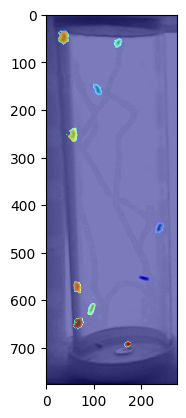

In [ ]:
def region_growing_bfs(image, seed_point, threshold):
    height, width = image.shape
    visited = np.zeros_like(image, dtype=bool)
    segmented_image = np.zeros_like(image)
    queue = [(image[seed_point], seed_point)]
    heapq.heapify(queue)
    segmented_image[seed_point] = 255
    visited[seed_point] = True

    while queue:
        _, current_point = heapq.heappop(queue)
        y, x = current_point

        # Explore neighbors in all 8 directions
        neighbors = [(y + dy, x + dx) for dy in [-1, 0, 1] for dx in [-1, 0, 1] if (dy != 0 or dx != 0)]

        # Create a priority queue for neighbors based on pixel value
        neighbor_queue = [(image[ny, nx], (ny, nx)) for ny, nx in neighbors if 0 <= ny < height and 0 <= nx < width and not visited[ny, nx] and (image[ny, nx] > image[y, x] or image[ny, nx] < threshold)]
        heapq.heapify(neighbor_queue)

        while neighbor_queue:
            _, neighbor_point = heapq.heappop(neighbor_queue)
            ny, nx = neighbor_point
            if not visited[ny, nx]:
                segmented_image[ny, nx] = 255
                visited[ny, nx] = True
                heapq.heappush(queue, (image[ny, nx], (ny, nx)))  # Add to main queue for next depth level

    return segmented_image

# Create a copy of movement_frame
temp_movement_frame = copy.deepcopy(movement_frame2)
from scipy.ndimage import median_filter
temp_movement_frame = median_filter(temp_movement_frame, size=3)  # Example size=3

# Find darkest spots and perform region growing on the copy
labeled_image = np.zeros_like(temp_movement_frame, dtype=int)
label = 1
cnt = 0
while cnt < 10:
    cnt = cnt + 1
    min_val = np.min(temp_movement_frame)
    min_coords = np.unravel_index(np.argmin(temp_movement_frame), temp_movement_frame.shape)

    segmented_region = region_growing_bfs(temp_movement_frame, min_coords, 220)

    num_pixels = np.count_nonzero(segmented_region)
    signal_strength = temp_movement_frame[segmented_region == 255].sum() / num_pixels
    if signal_strength == 255: break
    temp_movement_frame[segmented_region == 255] = 255
    print(num_pixels, signal_strength)
    if num_pixels <= 50 or num_pixels >= 2500:
      cnt = cnt - 1
      continue

    labeled_image[segmented_region == 255] = label
    label += 1

# Display the labeled image
plt.imshow(labeled_image, cmap='jet')
plt.imshow(random_frame, cmap='gray', alpha=0.5)
plt.show()